In [1]:
from multiprocessing import Pool
import os
import time
import utils
import emcee
import numpy as np
import scipy.special
import pandas as pd
import matplotlib.pyplot as plt
import corner
import seaborn as sns
import pickle
import scanpy as sc
import glob
import multiprocessing

In [2]:
multiprocessing.set_start_method("fork")

cor, pal = utils.matplotlib_style()

# Set random seed
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

# Set number of threads for other non-pool processes to one to avoid conflicts
# with emcee
os.environ["OMP_NUM_THREADS"] = "1"

# Single-cell RNA-seq "MNIST" dataset

In this notebook, we will explore the inference over a [recently
published](https://www.biorxiv.org/content/10.1101/2021.12.08.471773v1) dataset
aiming to mimic the MNIST dataset in the single-cell RNA-seq space. The details
of the dataset do not matter much for the purpose of this notebook. The key is
to get a sense of the type of data that we are dealing with.

The dataset is provided in `h5ad` format and can be downloaded from [this Zenodo
repository](https://zenodo.org/records/7795653). Let's start by listing the
available files in the dataset.

In [3]:
# List all files in the data directory
files = glob.glob("../data/scmark_v2/scmark_v2/*.h5ad")

files

['../data/scmark_v2/scmark_v2/external_qian_cellres_2020_32561858.h5ad',
 '../data/scmark_v2/scmark_v2/external_nath_natcommun_2021_34031395.h5ad',
 '../data/scmark_v2/scmark_v2/external_lee_natgenet_2020_32451460.h5ad',
 '../data/scmark_v2/scmark_v2/external_bi_cancercell_2021_33711272.h5ad',
 '../data/scmark_v2/scmark_v2/external_zhang_procnatlacadsciusa_2021_34099557.h5ad',
 '../data/scmark_v2/scmark_v2/external_karlsson_sciadv_2021_34321199.h5ad',
 '../data/scmark_v2/scmark_v2/external_peng_cellres_2019_31273297.h5ad',
 '../data/scmark_v2/scmark_v2/external_azizi_cell_2018_29961579.h5ad',
 '../data/scmark_v2/scmark_v2/external_slyper_natmed_2020_32405060.h5ad',
 '../data/scmark_v2/scmark_v2/external_bassez_natmed_2021_33958794.h5ad',
 '../data/scmark_v2/scmark_v2/external_elyada_cancerdiscov_2019_31197017.h5ad']

Since we have no specific interest in the dataset itself, we can pick one of
the datasets at random and use it for the purpose of this notebook. Let's load
one of these datasets.

In [4]:
# Load the first file
data = sc.read_h5ad(files[0])

data

AnnData object with n_obs × n_vars = 10003 × 33515
    obs: 'barcode', 'sample_name', 'disease_name', 'study_name', 'standard_true_celltype', 'disease_subtype', 'indication_name', 'tumor_stage', 'split'
    var: 'gene'

The dataset contains 10,003 cells and 33,515 unique genes. Let's extract the 
data into a DataFrame.

In [5]:
# Extract the counts into a pandas dataframe
df_counts = pd.DataFrame(
    data.X.toarray(),
    columns=data.var.gene,
    index=data.obs.index
)

print(df_counts.shape)
df_counts.head()

(10003, 33515)


gene,MIR1302-2HG,FAM138A,OR4F5,RP11-34P13.7,AL627309.3,AL627309.2,AL627309.4,FO538757.3,FO538757.2,AP006222.2,...,AC007325.2,BX072566.1,AL354822.1,AC023491.2,AC004556.1,AC233755.2,AC233755.1,AC240274.1,AC213203.1,FAM231B
index,,,,,,,,,,,,,,,,,,,,,
scrEXT021_TGGCTGGTCTCGCTTG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
scrEXT021_CAAGAAACACAGCGTC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
scrEXT021_CTCGGAGGTCAAAGCG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
scrEXT021_TACCTTACAACACCTA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
scrEXT021_GCACATAAGATATACG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's look at a few example ECDFs from the dataset. We will select a few genes
based on their mean count and plot the ECDFs for these genes.

In [6]:
# Define number of genes to select
n_genes = 9

# Compute the mean expression of each gene and sort them
df_mean = df_counts.mean().sort_values(ascending=False)

# Remove all genes with mean expression less than 1
df_mean = df_mean[df_mean > 1]

# Generate logarithmically spaced indices
log_indices = np.logspace(
    0, np.log10(len(df_mean) - 1), num=n_genes, dtype=int
)

# Select genes using the logarithmically spaced indices
genes = df_mean.iloc[log_indices].index

df_mean[genes]

gene
IGKC      149.417374
FTL        70.560234
MT-CO1     61.061680
MT-CO2     45.110668
MT-ND2     25.638109
RPS23      15.526742
NEAT1       7.498250
NFKBIA      2.269519
CTSC        1.001400
dtype: float32

Let's now plot the ECDFs for these genes.

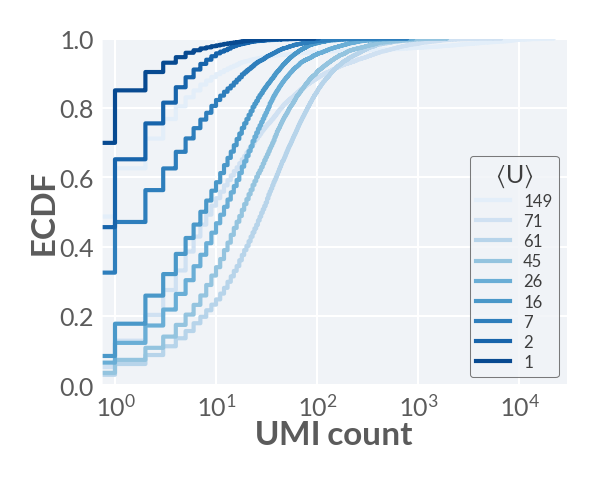

In [7]:
# Initialize figure
fig, ax = plt.subplots(1, 1, figsize=(2, 1.5))

# Define step size for ECDF
step = 1

# Loop throu each gene
for (i, gene) in enumerate(genes):
    # Plot the ECDF for each column in the DataFrame
    sns.ecdfplot(
        data=df_counts,
        x=gene,
        ax=ax,
        color=sns.color_palette('Blues', n_colors=n_genes)[i],
        label=np.round(df_mean[gene], 0).astype(int),
        lw=1
    )

# Set x-axis to log scale
ax.set_xscale('log')

# Add axis labels
ax.set_xlabel('UMI count')
ax.set_ylabel('ECDF')

# Add legend
ax.legend(loc='lower right', fontsize=4, title=r"$\langle U \rangle$")

This seems like a good representative sample of the data.

## Bayesian Inference of the two-state promoter model

In [8]:
def log_prior(params, bounds):
    """
    Compute the log prior for kinetic parameters in a two-state promoter model.

    This function evaluates the log prior probability of the given kinetic
    parameters based on uniform priors. The ru_koff parameter is assumed to be
    in log scale. If any parameter is outside the specified bounds, the function
    returns negative infinity, indicating that the parameter set is not allowed.

    Parameters
    ----------
    params : array-like, shape (3,)
        An array containing the kinetic parameters for the steady state UMI
        distribution: 
        - kp_on (float): Rate of activation of the promoter. 
        - ru (float): Production rate of the mRNA. 
        - log_ru_koff (float): Log of the ratio of production rate to the rate 
          of deactivation of the promoter.
    bounds : dict
        A dictionary containing the bounds for each parameter:
        - 'kp_on': tuple (kp_on_min, kp_on_max)
        - 'ru': tuple (ru_min, ru_max)
        - 'log_ru_koff': tuple (log_ru_koff_min, log_ru_koff_max)

    Returns
    -------
    float
        The log prior probability of the parameters. Returns negative infinity
        if any parameter is outside the allowable range, indicating an invalid
        parameter set.

    Notes
    -----
    The function computes the rate of deactivation (k_off) from the production
    rate (ru) and the exponentiated log ratio (log_ru_koff). The priors are 
    defined as uniform distributions within the specified bounds.
    """
    # Unpack parameters
    kp_on, ru, log_ru_koff = params

    # Check if parameters are within bounds
    if not (bounds['log_kp_on'][0] <= kp_on <= bounds['log_kp_on'][1]):
        return -np.inf
    if not (bounds['log_ru'][0] <= ru <= bounds['log_ru'][1]):
        return -np.inf
    if not (bounds['log_ru_koff'][0] <= log_ru_koff <= bounds['log_ru_koff'][1]):
        return -np.inf

    # If all parameters are within bounds, return 0.0 (log of 1)
    return 0.0

In [9]:
def log_likelihood_two_state(params, data):
    """
    Compute the log likelihood for the two-state promoter UMI count distribution.

    This function calculates the log likelihood of observing the given unique
    molecular identifier (UMI) counts based on the two-state promoter model
    parameters.

    Parameters
    ----------
    params : array-like, shape (3,)
        An array containing the parameters for the steady state UMI distribution:
        - kp_on (float): Rate of activation of the promoter.
        - ru (float): Production rate of the mRNA.
        - log_ru_koff (float): Log of the ratio of production rate to the rate of
          deactivation of the promoter.
    data : array-like, shape (n, 2)
        An array containing the observed UMI counts and their frequencies:
        - data[:, 0] (int): Unique UMI counts.
        - data[:, 1] (int): Frequency of each UMI count.

    Returns
    -------
    float
        The log likelihood of the observed data given the model parameters.

    Notes
    -----
    The likelihood calculation is optimized by using unique UMI entries and
    their corresponding counts. Instead of computing the probability of each UMI
    count multiple times, the function computes it once for each unique count
    and multiplies the result by the frequency of that count.
    """
    # Unpack parameters
    kp_on, ru, log_ru_koff = params
    # Compute kp_off from ru and exp(log_ru_koff)
    kp_off = ru / np.exp(log_ru_koff)
    # Unpack data
    umi, counts = data[:, 0], data[:, 1]
    return np.sum(
        counts * utils.two_state_log_probability(umi, kp_on, kp_off, ru)
    )

def log_likelihood_neg_binom(params, data):
    """
    Compute the log likelihood for the negative binomial approximation of the
    two-state promoter UMI count distribution.

    This function calculates the log likelihood of observing the given unique
    molecular identifier (UMI) counts based on the negative binomial approximation
    of the two-state promoter model parameters.

    Parameters
    ----------
    params : array-like, shape (3,)
        An array containing the parameters for the steady state UMI distribution:
        - kp_on (float): Rate of activation of the promoter.
        - ru (float): Production rate of the mRNA.
        - log_ru_koff (float): Log of the ratio of production rate to the rate of
          deactivation of the promoter.
    data : array-like, shape (n, 2)
        An array containing the observed UMI counts and their frequencies:
        - data[:, 0] (int): Unique UMI counts.
        - data[:, 1] (int): Frequency of each UMI count.

    Returns
    -------
    float
        The log likelihood of the observed data given the model parameters.

    Notes
    -----
    This function uses the negative binomial approximation, which is valid when
    kp_off >> 1. The likelihood calculation is optimized by using unique UMI
    entries and their corresponding counts.
    """
    # Unpack parameters
    kp_on, ru, log_ru_koff = params
    # Compute kp_off from ru and exp(log_ru_koff)
    kp_off = ru / np.exp(log_ru_koff)
    # Unpack data
    umi, counts = data[:, 0], data[:, 1]
    return np.sum(
        counts * utils.two_state_neg_binom_log_probability(
            umi, kp_on, kp_off, ru
        )
    )

In [10]:
def log_posterior(params, data, bounds, log_sampling=True):
    """
    Compute the log posterior for the two-state promoter model with log ratio.

    This function calculates the log posterior probability of the given
    parameters based on the observed data, prior distributions, and the
    two-state promoter model. It supports sampling in either linear or log
    scale for kp_on and ru, while log_ru_koff is always in log scale.

    Parameters
    ----------
    params : array-like, shape (3,)
        An array containing the kinetic parameters for the steady state UMI
        distribution: 
            - kp_on (float): Rate of activation of the promoter. 
            - ru (float): Production rate of the mRNA.
            - log_ru_koff (float): Log of the ratio of production rate to the 
              rate of deactivation of the promoter.
    data : array-like, shape (n, 2)
        An array containing the observed UMI counts and their frequencies: 
            - data[:, 0] (int): Unique UMI counts. 
            - data[:, 1] (int): Frequency of each UMI count.
    bounds : dict
        A dictionary containing the bounds for each parameter:
            - 'kp_on': tuple (kp_on_min, kp_on_max)
            - 'ru': tuple (ru_min, ru_max)
            - 'log_ru_koff': tuple (log_ru_koff_min, log_ru_koff_max)
    log_sampling : bool, optional
        If True, kp_on and ru are assumed to be in log scale and will be
        exponentiated before further calculations. Default is False.

    Returns
    -------
    float
        The log posterior probability of the parameters. Returns negative
        infinity if the parameters are outside the allowable range or if the log
        prior is negative infinity.
    """
    # Compute log prior
    lp = log_prior(params, bounds)

    # If log prior is -inf, return that
    if lp == -np.inf:
        return -np.inf

    # If log_sampling is True, exponentiate kp_on and ru
    if log_sampling:
        # Unpack parameters
        log_kp_on, log_ru, log_ru_koff = params
        # Exponentiate parameters
        kp_on, ru = np.exp(log_kp_on), np.exp(log_ru)
        # Compute kp_off from ru and exp(log_ru_koff)
        kp_off = ru / np.exp(log_ru_koff)
        # Compute parameters in linear scale
        params = [kp_on, ru, log_ru_koff]
                
    
    if kp_off > 100 * kp_on:
        # Compute and return approximate posterior
        return lp + log_likelihood_neg_binom(params, data)
    else:
        # Compute and return posterior
        return lp + log_likelihood_two_state(params, data)

Having defined the Bayesian model, we can now run the MCMC sampler. We will use
the `emcee` package to run the sampler. Let's begin with a single gene.

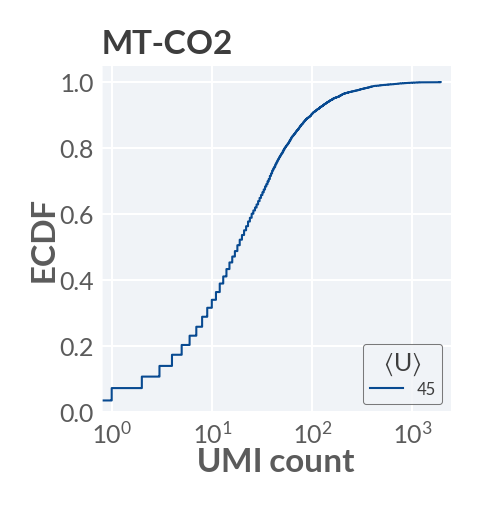

In [11]:
# Define gene
gene = genes[3]
# Extract the counts for the gene
counts = df_counts[gene].to_numpy()
# Generate matrix with unique values and their counts needed for the
# likelihood function
data = np.array(np.unique(counts, return_counts=True)).T

# Initialize figure
fig, ax = plt.subplots(1, 1, figsize=(1.5, 1.5))

# Plot the ECDF for each column in the DataFrame
sns.ecdfplot(
    data=df_counts,
    x=gene,
    ax=ax,
    color=sns.color_palette('Blues', n_colors=n_genes)[i],
    label=np.round(df_mean[gene], 0).astype(int),
    lw=0.5
)

# Set y-axis upper limit to 1
ax.set_ylim(0, 1.05)

# Add title
ax.set_title(f"{gene}")

# Add axis labels
ax.set_xlabel('UMI count')
ax.set_ylabel('ECDF')

# Set x-axis to log scale
ax.set_xscale('log')

# Add legend
ax.legend(loc='lower right', fontsize=4, title=r"$\langle U \rangle$")

Next, let's define the bounds for the parameters and the initial guess for the
sampler.

In [12]:
np.random.seed(42)

# Define the parameters for emcee
n_dim = 3  # number of parameters to fit
n_walkers = 32  # number of walkers
n_burn = 1_000  # number of burn-in steps
n_steps = 5_000  # number of steps to run the sampler

# Define the bounds for the parameters
bounds = {
    'log_kp_on': (np.log(1e-6), np.log(100)), 
    'log_ru': (np.log(1e-6), np.log(10_000)), 
    'log_ru_koff': (np.log(1e-4), np.log(10))
}

# Initialize walkers
p0 = np.zeros([n_walkers, n_dim])
# Initialize kp_on
p0[:, 0] = np.random.uniform(
    bounds['log_kp_on'][0], bounds['log_kp_on'][1], n_walkers
    )
# Initialize ru
p0[:, 1] = np.random.uniform(
    bounds['log_ru'][0], bounds['log_ru'][1], n_walkers
)
# Initialize log_ru_koff
p0[:, 2] = np.random.uniform(
    bounds['log_ru_koff'][0], bounds['log_ru_koff'][1], n_walkers
)

Now we are ready to run the sampler.

In [14]:
np.random.seed(42)

# Define output filename
out_file = f"emcee_chain/scmark_{gene}_two_state_mcmc_{n_walkers}walkers_{n_burn}burn_{n_steps}steps.pkl"

# Check if file exists
if not os.path.exists(out_file):
    print(f"Running sampler for gene {gene}")
    # Run sampling in multiprocessing
    with Pool() as pool:
        # Initialize sampler
        sampler = emcee.EnsembleSampler(
            n_walkers, 
            n_dim, 
            log_posterior,
            args=(data, bounds, True), 
            pool=pool
        )
        # Set time at the beginning of the run
        start = time.time()
        # Run the MCMC sampling
        sampler.run_mcmc(p0, n_burn + n_steps, progress=True)
        # Set time at the end of the run
        end = time.time()
        # Quantify the time taken
        multi_time = end - start
        # print the time taken
        print("MCMC ran in {0:.1f} seconds".format(multi_time))
        # Open a file to save the chain
        output = open(out_file, "wb")
        # Dump the chain and the lnprobability to
        pickle.dump(sampler.chain, output)
        pickle.dump(sampler.lnprobability, output)
        # Close the file
        output.close()

Running sampler for gene MT-CO2


  0%|          | 4/6000 [00:49<20:47:29, 12.48s/it]


KeyboardInterrupt: 

Let's load the chain.

In [ ]:
# Load the flat-chain
with open(out_file, "rb") as file:
    # Open the file
    unpickler = pickle.Unpickler(file)
    # Load the chain
    chain = unpickler.load()
    # Load the lnprobability
    lnprobability = unpickler.load()

# Remove burn-in
chain = chain[:, n_burn:, :]

And look at the corner plot.

In [ ]:
# Initialize subplot
fig, axes = plt.subplots(3, 3, figsize=(3.5, 3.5))

# Draw the corner plot
fig = corner.corner(
    chain,
    bins=50,
    plot_contours=True,
    labels=[r'$\ln(k^{(p)}_{on})$', r'$\ln(r_u)$', r'$\ln(r_u/k^{(p)}_{off})$', ],
    fig=fig
)

# Remove grid lines from all axes
for ax in axes.flatten():
    ax.grid(False)

Having defined the Bayesian model, we can now run the MCMC sampler. We will use
the `emcee` package to run the sampler. First, we need to define the bounds for
the parameters and the initial guess for the sampler.

In [ ]:
np.random.seed(42)

# Define the parameters for emcee
n_dim = 3  # number of parameters to fit
n_walkers = 32  # number of walkers
n_burn = 2_000  # number of burn-in steps
n_steps = 5_000  # number of steps to run the sampler

# Define the bounds for the parameters
bounds = {
    'kp_on': (1e-5, 100), 'ru': (1e-5, 800), 'log_ru_koff': (-5, np.log(10))
}

# Initialize walkers
p0 = np.zeros([n_walkers, n_dim])
# Initialize kp_on
p0[:, 0] = np.random.uniform(
    bounds['kp_on'][0], bounds['kp_on'][1], n_walkers
    )
# Initialize ru
p0[:, 1] = np.random.uniform(
    bounds['ru'][0], bounds['ru'][1], n_walkers
)
# Initialize log_ru_koff
p0[:, 2] = np.random.uniform(
    bounds['log_ru_koff'][0], bounds['log_ru_koff'][1], n_walkers
)

Now we can define the sampler and sample in parallel.

In [ ]:
# Loop through each gene and sample
for (i, gene) in enumerate(genes):
    print(f"Running sampler for gene {gene}")
    # Define output filename
    out_file = f"emcee_chain/scmark_{gene}_two_state_mcmc_{n_walkers}walkers_{n_burn}burn_{n_steps}steps.pkl"
    # Check if file exists
    if os.path.exists(out_file):
        continue
    # Extract the counts for the gene
    counts = df_counts[gene].to_numpy()
    # Generate matrix with unique values and their counts needed for the
    # likelihood function
    data = np.array(np.unique(counts, return_counts=True)).T
    # Run the sampler in parallel
    with Pool() as pool:
        sampler = emcee.EnsembleSampler(
            n_walkers, n_dim, log_posterior, args=(data, bounds), pool=pool
        )
        # Set time at the beginning of the run
        start = time.time()
        # Run the MCMC sampling
        sampler.run_mcmc(p0, n_burn + n_steps, progress=True)
        # Set time at the end of the run
        end = time.time()
        # Quantify the time taken
        multi_time = end - start
        # print the time taken
        print("MCMC ran in {0:.1f} seconds".format(multi_time))
        # Open a file to save the chain
        output = open(out_file, "wb")
        # Dump the chain and the lnprobability to
        pickle.dump(sampler.chain, output)
        pickle.dump(sampler.lnprobability, output)
        # Close the file
        output.close()

Let's now load the chains and plot the posterior distributions for each
parameter. First, let's list the files in the `emcee_chain` directory.

In [ ]:
# List all files in the emcee_chain directory
files = glob.glob("emcee_chain/scmark_*.pkl")

files

Let's load one of the files and show a corner plot of the posterior
distributions.

In [ ]:
# Load the flat-chain
with open(files[0], "rb") as file:
    # Open the file
    unpickler = pickle.Unpickler(file)
    # Load the chain
    chain = unpickler.load()
    # Load the lnprobability
    lnprobability = unpickler.load()

# Initialize subplot
fig, axes = plt.subplots(3, 3, figsize=(3.5, 3.5))

# Plot the chains
fig = corner.corner(
    chain, 
    bins=50,
    plot_contours=True,
    labels=[r'$k^{(p)}_{on}$', r'$r_u$', r'$\ln(r_u/k^{(p)}_{off})$', ],
    fig=fig,
)

# Remove grid lines from all axes
for ax in axes.flatten():
    ax.grid(False)